PCI: 165


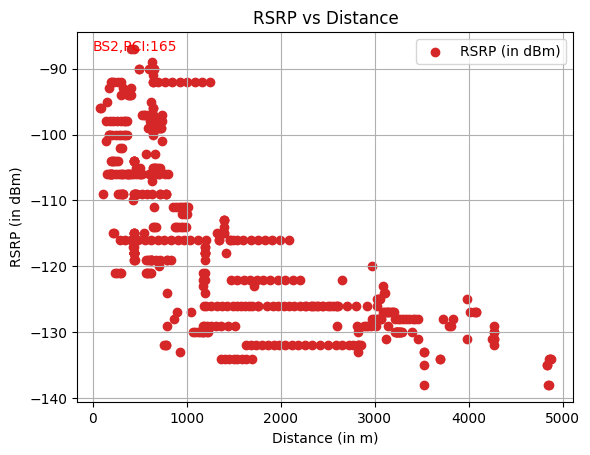

In [2]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
import sys
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

fix_pci = 165
rx_height = 1.5
# fix_pci = int(input('Enter PCI: '))
print(f"PCI: {fix_pci}")
match fix_pci:
    case 14 | 88:
        fix_freq = 3560e6
    case 189 | 1 | 96 | 26 | 187:
        fix_freq = 3580e6
    case 195 | 46:
        fix_freq = 3600e6
    case 6 | 150 | 10 | 200 | 165:
        fix_freq = 3670e6
    case 169 | 194 | 78 | 69:
        fix_freq = 3690e6
    case _:
        sys.exit()

match fix_pci: # https://www.fcc.gov/media/radio/dms-decimal
    case 189 | 195 | 6 | 150 | 169 | 194:
        # https://maps.app.goo.gl/5WMfETE9VkzZQvBx8
        bs_name = 'BS1'
        bs_lat = 41.65425
        bs_lon = -86.24375
        bs_height = 45
    case 1 | 10 | 200 | 165 | 78 | 69:
        # https://maps.app.goo.gl/HDvgbdpteGhEeBAk8
        bs_name = 'BS2'
        bs_lat = 41.663278
        bs_lon = -86.254139
        bs_height = 55
    case 14 | 88 | 96 | 26:
        # https://maps.app.goo.gl/GyG1Y2veuAiZMfw38
        bs_name = 'BS3'
        bs_lat = 41.67225
        bs_lon = -86.292778
        bs_height = 33
    case 187 | 46:
        # https://maps.app.goo.gl/nazumHiRpfgrL5kV8
        bs_name = 'BS4'
        bs_lat = 41.668678
        bs_lon = -86.312222
        bs_height = 13
    case _:
        sys.exit()

csv_files = glob.glob('sigcap_data/data/*.csv')
filtered_dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    filtered_df = df[df['pci'] == fix_pci]
    filtered_df = filtered_df[['latitude', 'longitude', 'altitude', 'pci', 'rsrp']]
    filtered_df['file_name'] = file
    filtered_dfs.append(filtered_df)
df_fix_pci = pd.concat(filtered_dfs)

del filtered_dfs, filtered_df, df, csv_files, file

def haversine(lat1, lon1, lat2, lon2, bs_height):
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371  # Radius of the Earth in kilometers
    distance_2d = c * r * 1e3
    distance_3d = np.sqrt(distance_2d**2 + (bs_height-rx_height)**2)
    return distance_2d, distance_3d

# df_fix_pci['distance'] = haversine(df_fix_pci['latitude'], df_fix_pci['longitude'], bs_lat, bs_lon, bs_height)
df_fix_pci[['distance_2d', 'distance_3d']] = df_fix_pci.apply(lambda row: haversine(row['latitude'], row['longitude'], bs_lat, bs_lon, bs_height), axis=1, result_type='expand')
df_fix_pci['distance_3d_log'] = 10*np.log10(df_fix_pci['distance_3d'])
# df_fix_pci['calc_theta'] = np.rad2deg(np.arctan(bs_height / df_fix_pci['distance']))

if fix_pci == 150:
    df_fix_pci = df_fix_pci[df_fix_pci['distance_3d'] < 1e3]
if fix_pci == 189:
    df_fix_pci = df_fix_pci[df_fix_pci['distance_3d'] < 2*1e3]
if fix_pci == 96:
    df_fix_pci = df_fix_pci[df_fix_pci['distance_3d'] < 1e5]
if fix_pci == 46:
    df_fix_pci = df_fix_pci[df_fix_pci['distance_3d'] < 1e5]
if fix_pci == 187:
    df_fix_pci = df_fix_pci[df_fix_pci['distance_3d'] < 1e5]

# plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp'], color='tab:red')
plt.legend(['RSRP (in dBm)'])
plt.xlabel('Distance (in m)')
plt.ylabel('RSRP (in dBm)')
plt.title('RSRP vs Distance')
plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
plt.grid()
plt.show()

Slope: [-2.49142966]
Intercept: [-41.35587379]
RMSE for regression model: 8.42


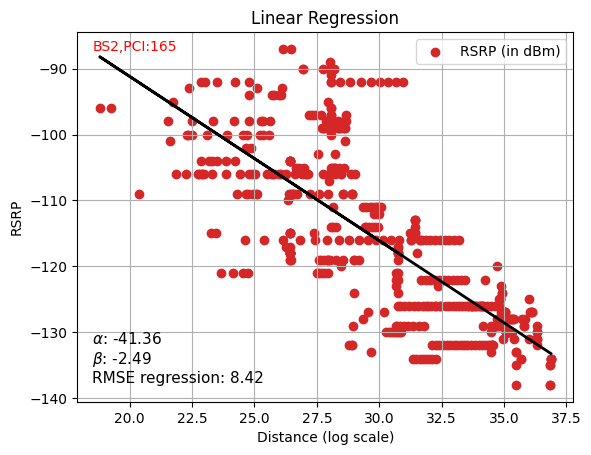

In [3]:
from sklearn.metrics import mean_squared_error

# Linear Regression
x = df_fix_pci['distance_3d_log'].values.reshape(-1, 1)
y = df_fix_pci['rsrp'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(x,y)
beta_regression = model.coef_[0]
alpha_regression = model.intercept_
print("Slope:", beta_regression)
print("Intercept:", alpha_regression)

rmse_regression = root_mean_squared_error(y, model.predict(x))
print(f"RMSE for regression model: {rmse_regression:.2f}")

plt.scatter(x, y, color='tab:red')
plt.plot(x, alpha_regression+beta_regression*x, color='black', linewidth=2)
plt.legend(['RSRP (in dBm)'])
plt.xlabel('Distance (log scale)')
plt.ylabel('RSRP')
plt.title('Linear Regression')
plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
plt.text(0.03, 0.05, rf"$\alpha$: {float(alpha_regression[0]):.2f}" "\n" rf"$\beta$: {float(beta_regression[0]):.2f}" "\n" rf"RMSE regression: {rmse_regression:.2f}", transform=plt.gca().transAxes, fontsize=11)
plt.grid()
plt.show()

# del x, y, model

RMSE for Friis model: 32.33


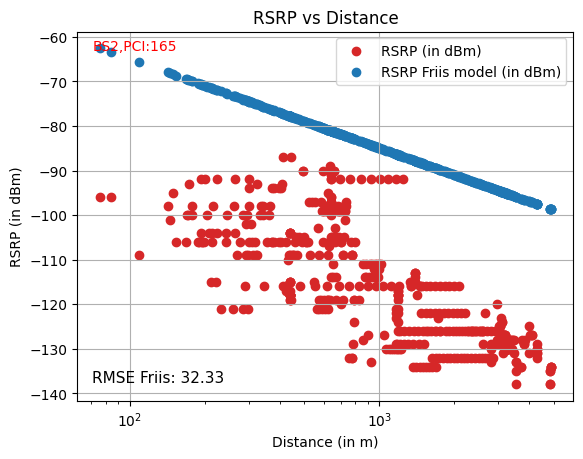

In [4]:
# Friis model
df_fix_pci['pl_friis'] = 32.4+20*np.log10(df_fix_pci['distance_3d']/1e3)+20*np.log10(fix_freq/1e6)
df_fix_pci['rsrp_pl_friis'] = 18.75 - df_fix_pci['pl_friis']

rmse_friis = root_mean_squared_error(df_fix_pci['rsrp_pl_friis'], df_fix_pci['rsrp'])
print(f"RMSE for Friis model: {rmse_friis:.2f}")

plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp'], color='tab:red')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp_pl_friis'], color='tab:blue')
plt.legend(['RSRP (in dBm)', 'RSRP Friis model (in dBm)'])
plt.xlabel('Distance (in m)')
plt.ylabel('RSRP (in dBm)')
plt.title('RSRP vs Distance')
plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
plt.text(0.03, 0.05, f"RMSE Friis: {rmse_friis:.2f}", transform=plt.gca().transAxes, fontsize=11)
plt.grid()
plt.show()

Breakpoint distance: 4037.00 m
RMSE for 3GPP UMa LOS model: 31.21
RMSE for 3GPP UMa NLOS model: 36.54
RMSE for 3GPP UMa NLOS (optional) model: 59.47


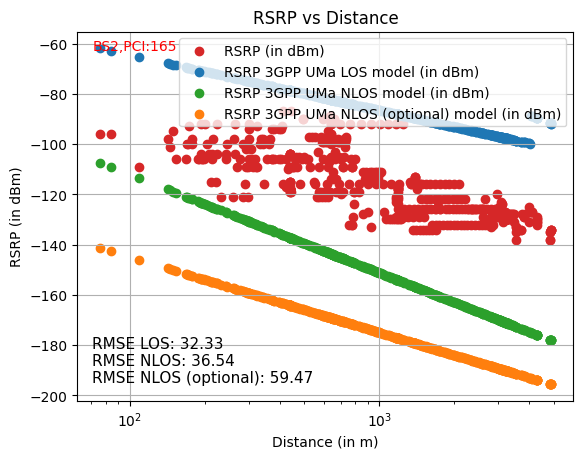

In [5]:
# 3GPP UMa LOS model
d_bp_3gpp = 4*bs_height*1.5*fix_freq/(3e8)
print(f"Breakpoint distance: {d_bp_3gpp:.2f} m")

df_fix_pci['pl_3gpp_uma_los'] = np.where(df_fix_pci['distance_2d'] < d_bp_3gpp, 28+22*np.log10(df_fix_pci['distance_3d'])+20*np.log10(fix_freq/1e9),\
                                     28+40*np.log10(df_fix_pci['distance_3d'])+20*np.log10(fix_freq)/1e9-9*np.log10((d_bp_3gpp)**2+(bs_height-rx_height)**2))
df_fix_pci['rsrp_pl_3gpp_uma_los'] = 18.75 - df_fix_pci['pl_3gpp_uma_los']

df_fix_pci['pl_3gpp_uma_nlos_temp'] = 13.54+39.08*np.log10(df_fix_pci['distance_3d'])+20*np.log10(fix_freq/1e6)-0.6*(bs_height-rx_height)
df_fix_pci['pl_3gpp_uma_nlos'] = np.maximum(df_fix_pci['pl_3gpp_uma_nlos_temp'], df_fix_pci['pl_3gpp_uma_los'])
df_fix_pci.drop('pl_3gpp_uma_nlos_temp', axis=1, inplace=True)
df_fix_pci['rsrp_pl_3gpp_uma_nlos'] = 18.75 - df_fix_pci['pl_3gpp_uma_nlos']

df_fix_pci['pl_3gpp_uma_nlos_optional'] = 32.4+20*np.log10(fix_freq/1e6)+30*np.log10(df_fix_pci['distance_3d'])
df_fix_pci['rsrp_pl_3gpp_uma_nlos_optional'] = 18.75 - df_fix_pci['pl_3gpp_uma_nlos_optional']

rmse_3gpp_uma_los = root_mean_squared_error(df_fix_pci['rsrp_pl_3gpp_uma_los'], df_fix_pci['rsrp'])
rmse_3gpp_uma_nlos = root_mean_squared_error(df_fix_pci['rsrp_pl_3gpp_uma_nlos'], df_fix_pci['rsrp'])
rmse_3gpp_uma_nlos_optional = root_mean_squared_error(df_fix_pci['rsrp_pl_3gpp_uma_nlos_optional'], df_fix_pci['rsrp'])
print(f"RMSE for 3GPP UMa LOS model: {rmse_3gpp_uma_los:.2f}")
print(f"RMSE for 3GPP UMa NLOS model: {rmse_3gpp_uma_nlos:.2f}")
print(f"RMSE for 3GPP UMa NLOS (optional) model: {rmse_3gpp_uma_nlos_optional:.2f}")

plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp'], color='tab:red')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp_pl_3gpp_uma_los'], color='tab:blue')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp_pl_3gpp_uma_nlos'], color='tab:green')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp_pl_3gpp_uma_nlos_optional'], color='tab:orange')
plt.legend(['RSRP (in dBm)', 'RSRP 3GPP UMa LOS model (in dBm)', 'RSRP 3GPP UMa NLOS model (in dBm)',\
            'RSRP 3GPP UMa NLOS (optional) model (in dBm)'],loc='upper right')
plt.xlabel('Distance (in m)')
plt.ylabel('RSRP (in dBm)')
plt.title('RSRP vs Distance')
plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
plt.text(0.03, 0.05, f"RMSE LOS: {rmse_friis:.2f}\nRMSE NLOS: {rmse_3gpp_uma_nlos:.2f}\nRMSE NLOS (optional): {rmse_3gpp_uma_nlos_optional:.2f}", transform=plt.gca().transAxes, fontsize=11)
plt.grid()
plt.show()

RMSE for Ericsson model: 28.03


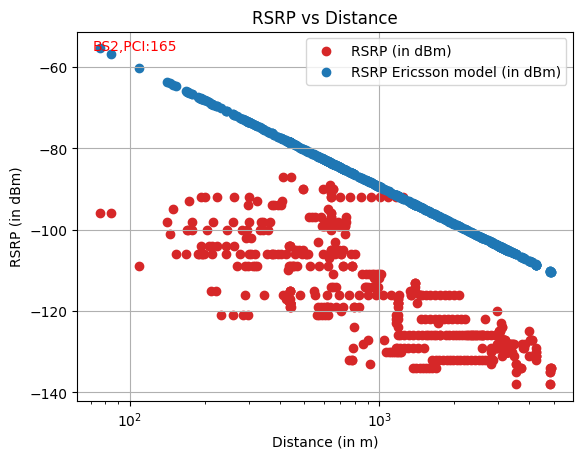

In [6]:
# Ericsson model
gf_erricson = 44.49*np.log10(fix_freq/1e6) - 4.78*(np.log10(fix_freq/1e6)**2)
# for urban environments, (a0, a1, a2, a3) = (36.2, 30.2, -12, 0.1)
a0 = 36.2; a1 = 30.2; a2 = -12; a3 = 0.1
df_fix_pci['pl_ericsson'] = a0 + a1*np.log10(df_fix_pci['distance_3d']/1e3) + a2*np.log10(bs_height) + a3*np.log10(bs_height)*np.log10(df_fix_pci['distance_3d']/1e3) - 3.2*((np.log10(11.75*rx_height))**2) + gf_erricson
df_fix_pci['rsrp_ericsson'] = 18.75 - df_fix_pci['pl_ericsson']

rmse_ericsson = np.sqrt(np.mean((df_fix_pci['rsrp'] - df_fix_pci['rsrp_ericsson'])**2))
print(f"RMSE for Ericsson model: {rmse_ericsson:.2f}")

plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp'], color='tab:red')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp_ericsson'], color='tab:blue')
plt.legend(['RSRP (in dBm)', 'RSRP Ericsson model (in dBm)'])
plt.xlabel('Distance (in m)')
plt.ylabel('RSRP (in dBm)')
plt.title('RSRP vs Distance')
plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
plt.grid()
plt.show()

RMSE for ITU-rural model: 24.48
RMSE for ITU-suburban model: 13.45
RMSE for ITU-urban model: 10.43


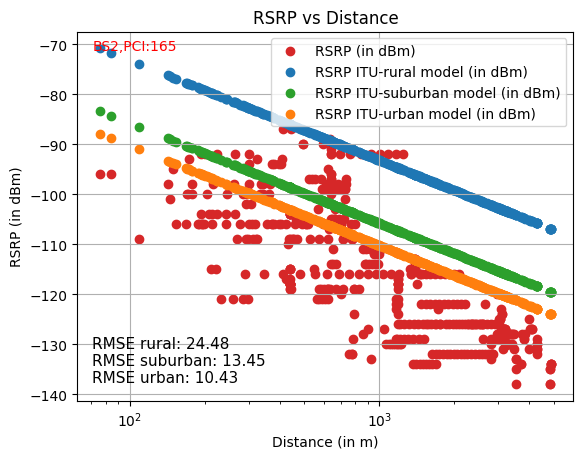

In [7]:
# ITU-R model

def ITU_HeightGainTerminalCorrectionModel(fix_freq,rx_height,env_flag_itu):
    # 1 for open/rural, 2 for suburban, 3 for urban/trees/forest
    if env_flag_itu == 1 or env_flag_itu == 2:
        R_itu = 10 
    else:
        R_itu = 15
    if rx_height >= R_itu:
        A_h_itu = 0
    else:
        k_nu_itu = 0.342*np.sqrt(fix_freq/1e9)
        k_h2_itu = 21.8 + 6.2*np.log10(fix_freq/1e9)
        w_s_itu = 27
        h_dif_itu = R_itu - rx_height
        theta_clut_itu = np.arctan(h_dif_itu/w_s_itu)
        mu_itu = k_nu_itu*np.sqrt(h_dif_itu*theta_clut_itu)
        if env_flag_itu == 1:
            J_mu_itu = 6.9 + 20*np.log10(np.sqrt( (mu_itu-0.1)**2 + 1 ) + mu_itu - 0.1)
            A_h_itu = J_mu_itu - 6.03
        else:
            A_h_itu = -k_h2_itu * np.log10(rx_height/R_itu)
    return A_h_itu

df_fix_pci['pl_itu_rural'] = df_fix_pci['pl_friis'] + ITU_HeightGainTerminalCorrectionModel(fix_freq,rx_height,1)
df_fix_pci['pl_itu_suburban'] = df_fix_pci['pl_friis'] + ITU_HeightGainTerminalCorrectionModel(fix_freq,rx_height,2)
df_fix_pci['pl_itu_urban'] = df_fix_pci['pl_friis'] + ITU_HeightGainTerminalCorrectionModel(fix_freq,rx_height,3)
df_fix_pci['rsrp_itu_rural'] = 18.75 - df_fix_pci['pl_itu_rural']
df_fix_pci['rsrp_itu_suburban'] = 18.75 - df_fix_pci['pl_itu_suburban']
df_fix_pci['rsrp_itu_urban'] = 18.75 - df_fix_pci['pl_itu_urban']

rmse_itu_rural = np.sqrt(np.mean((df_fix_pci['rsrp'] - df_fix_pci['rsrp_itu_rural'])**2))
rmse_itu_suburban = np.sqrt(np.mean((df_fix_pci['rsrp'] - df_fix_pci['rsrp_itu_suburban'])**2))
rmse_itu_urban = np.sqrt(np.mean((df_fix_pci['rsrp'] - df_fix_pci['rsrp_itu_urban'])**2))
print(f"RMSE for ITU-rural model: {rmse_itu_rural:.2f}")
print(f"RMSE for ITU-suburban model: {rmse_itu_suburban:.2f}")
print(f"RMSE for ITU-urban model: {rmse_itu_urban:.2f}")

plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp'], color='tab:red') 
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp_itu_rural'], color='tab:blue')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp_itu_suburban'], color='tab:green')
plt.scatter(df_fix_pci['distance_3d'], df_fix_pci['rsrp_itu_urban'], color='tab:orange')
plt.legend(['RSRP (in dBm)', 'RSRP ITU-rural model (in dBm)', 'RSRP ITU-suburban model (in dBm)', 'RSRP ITU-urban model (in dBm)'], loc='upper right')
plt.xlabel('Distance (in m)')
plt.ylabel('RSRP (in dBm)')
plt.title('RSRP vs Distance')
plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
plt.text(0.03, 0.05, f"RMSE rural: {rmse_itu_rural:.2f}\nRMSE suburban: {rmse_itu_suburban:.2f}\nRMSE urban: {rmse_itu_urban:.2f}", transform=plt.gca().transAxes, fontsize=11)
plt.grid()
plt.show()

In [8]:
# Winner II model
# B1: Urban micro-cell; B2: Bad urban micro-cell (*** Note: B1 = B2) (*** Note: Didn't implement as needs rectangular street grid information)
# C1: Suburban macro-cell; C2: Urban macro-cell; C3: Bad urban macro-cell (*** Note: C2 = C3)
# D1: Rural macro-cell

d_dash_bp_winner2 = 4*(bs_height-1)*(rx_height-1)*fix_freq/(3e8)
d_bp_winner2 = 4*bs_height*rx_height*fix_freq/(3e8)

# df_fix_pci['pl_winner2_c1_los'] = np.where(df_fix_pci['distance_2d'] < d_bp_winner2, 41.2+23.8*np.log10(df_fix_pci['distance_2d'])+20*np.log10(fix_freq/5e9),\
#                                      11.65+40*np.log10(df_fix_pci['distance_2d'])+3.8*np.log10(fix_freq/5e9)-16.2*np.log10(bs_height*rx_height))
# df_fix_pci['rsrp_pl_winner2_c1_los'] = 18.75 - df_fix_pci['pl_winner2_c1_los']
# df_fix_pci['pl_winner2_c1_nlos'] = (44.9-6.55*np.log10(bs_height))*np.log10(df_fix_pci['distance_2d']) + 31.46 + 5.83*np.log10(bs_height) + 23*np.log10(fix_freq/5e9)
# df_fix_pci['rsrp_pl_winner2_c1_nlos'] = 18.75 - df_fix_pci['pl_winner2_c1_nlos']

df_fix_pci['pl_winner2_c2_los'] = np.where(df_fix_pci['distance_2d'] < d_dash_bp_winner2, 39+26*np.log10(df_fix_pci['distance_2d'])+20*np.log10(fix_freq/5e9),\
                                     13.47+40*np.log10(df_fix_pci['distance_2d'])+6*np.log10(fix_freq/5e9)-14*np.log10((bs_height-1)*(rx_height-1)))
df_fix_pci['rsrp_pl_winner2_c2_los'] = 18.75 - df_fix_pci['pl_winner2_c2_los']
df_fix_pci['pl_winner2_c2_nlos'] = (44.9-6.55*np.log10(bs_height))*np.log10(df_fix_pci['distance_2d']) + 34.46 + 5.83*np.log10(bs_height) + 23*np.log10(fix_freq/5e9)
df_fix_pci['rsrp_pl_winner2_c2_nlos'] = 18.75 - df_fix_pci['pl_winner2_c2_nlos']



# df_fix_pci['pl_winner2_d1_los'] = np.where(df_fix_pci['distance_2d'] < d_bp_winner2, 44.2+21.5*np.log10(df_fix_pci['distance_2d'])+20*np.log10(fix_freq/5e9),\
#                                      10.5+40*np.log10(df_fix_pci['distance_2d'])+1.5*np.log10(fix_freq/5e9)-18.5*np.log10(bs_height*rx_height))
# df_fix_pci['rsrp_pl_winner2_d1_los'] = 18.75 - df_fix_pci['pl_winner2_d1_los']
# df_fix_pci['pl_winner2_d1_nlos'] = 25.1*np.log10(df_fix_pci['distance_2d']) + 55.4 - 0.13*(bs_height-25)*np.log10(df_fix_pci['distance_2d']/100) - 0.9*(rx_height-1.5) + 21.3*np.log10(fix_freq/5e9)
# df_fix_pci['rsrp_pl_winner2_d1_nlos'] = 18.75 - df_fix_pci['pl_winner2_d1_nlos']

# rmse_winner2_c1_los = root_mean_squared_error(df_fix_pci['rsrp_pl_winner2_c1_los'], df_fix_pci['rsrp'])
# rmse_winner2_c1_nlos = root_mean_squared_error(df_fix_pci['rsrp_pl_winner2_c1_nlos'], df_fix_pci['rsrp'])
# print(f"RMSE for Winner II C1 LOS: {rmse_winner2_c1_los:.2f}")
# print(f"RMSE for Winner II C1 NLOS: {rmse_winner2_c1_nlos:.2f}")

# plt.semilogx([],[],label='_nolegend_')
# plt.scatter(df_fix_pci['distance_2d'], df_fix_pci['rsrp'], color='tab:red')
# plt.scatter(df_fix_pci['distance_2d'], df_fix_pci['rsrp_pl_winner2_c1_los'], color='tab:blue')
# plt.scatter(df_fix_pci['distance_2d'], df_fix_pci['rsrp_pl_winner2_c1_nlos'], color='tab:green')
# plt.legend(['RSRP (in dBm)', 'RSRP Winner II C1 LOS model (in dBm)', 'RSRP Winner II C1 NLOS model (in dBm)'])
# plt.xlabel('Distance (in m)')
# plt.ylabel('RSRP (in dBm)')
# plt.title('RSRP vs Distance')
# plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
# plt.text(0.03, 0.05, f"RMSE LOS: {rmse_winner2_c1_los:.2f}\nRMSE NLOS: {rmse_winner2_c1_nlos:.2f}", transform=plt.gca().transAxes, fontsize=11)
# plt.grid()
# plt.show()

In [ ]:
# ITS ITM model

